#  Generative adversarial networks

**"Deep neural net architectures comprised of two nets, pitting one against the other"**



## Pregled
* Uvod
* Struktura
* Rezultati
* TensorFlow implementacija

## Uvod
- Jedna od najinovativnijih i najpopularnijih novih ideja u ML u poslednjih 10 godina
- Generativni model
- [Svakim danom sve više radova](https://imgur.com/IFXxquc) 
- I dalje dosta detalja koje je potrebno dublje istražiti, težak trening
- **Osnovna ideja**: Dve mreže koje se "bore": generator i diskriminator
  - Treniramo ih naizmenično u isto vreme, nemamo fiksnu funkciju troška

## Struktura
- "Prevarant" i "policajac": prevarant uči sve bolje da pravi lažne novčanice, policajac uči sve bolje da ih razlikuje
  - **Rezultat**: lažne novčanice koje liče na prave
- Dakle, generator treba da generiše primere takve da diskriminator ne može da ih razlikuje od pravih
- [Trening režim](https://imgur.com/807GTFL)
- Generator menja svoje težine tako da dobije što veći skor od diskriminatora
- Diskriminator menja svoje težine tako da da što manji skor generatoru ali što veći skor realnim primerima
- Funkcija troška je mreža!
-**Trik**: treba paziti da diskriminator ne ode previše ispred generatora, ne treniramo ga do konvergencije
  - Ovaj i još mnogo trikova i dodataka kako bi se GAN uspešno istrenirao
  - [Rad koji lepo ilustruje neke od njih](https://arxiv.org/abs/1904.08994)
- **Jedan pogled na istoriju mašinskog učenja**:
  1. Potreban je feature engineering pre modela
  2. Neuralne mreže (nema potrebe za feature engineering-om ali nam treba cost funkcija)
  3. GAN (nema potrebe za cost funkcijom ali moramo da znamo kako da radimo optimizaciju)
  4. "Learning to learn" - mreža uči sama kako da radi optimizaciju
  
## Rezultati
- Aritmetika u latentnom prostoru
- Interpolacija između slika
- Super Resolution
- Interaktivni GAN
- Style transfer
- [Pregled zanimljivih primena i rezultata](https://medium.com/@jonathan_hui/gan-some-cool-applications-of-gans-4c9ecca35900)

## TensorFlow implementacija

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Epoch: 0


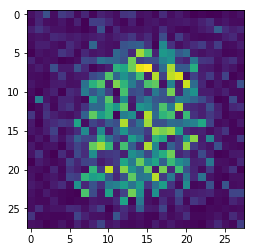

Epoch: 1


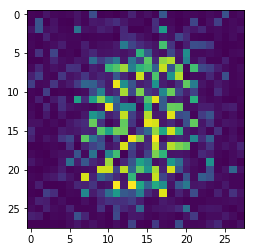

Epoch: 2


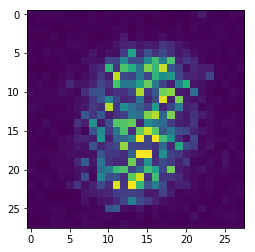

Epoch: 3


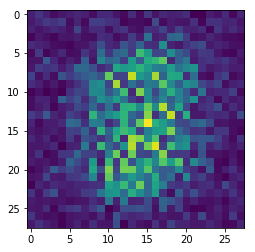

Epoch: 4


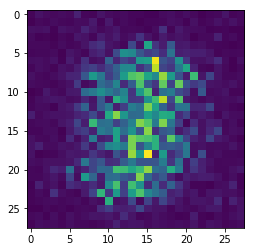

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

mnist=input_data.read_data_sets("MNIST_data")

# Generator uzima vektor manje dimenzije (z) i generise sliku 28x28
def generator(z,reuse=None):
  with tf.variable_scope('gen',reuse=reuse):
    hidden1 = tf.layers.dense(inputs=z,units=128,activation=tf.nn.leaky_relu)
    hidden2 = tf.layers.dense(inputs=hidden1,units=128,activation=tf.nn.leaky_relu)
    output = tf.layers.dense(inputs=hidden2,units=784,activation=tf.nn.tanh)

    return output
    
# Diskriminator uzima sliku (pravu ili laznu) i odredjuje njenu autenticnost
def discriminator(X,reuse=None):
  with tf.variable_scope('dis',reuse=reuse):
    hidden1 = tf.layers.dense(inputs=X,units=128,activation=tf.nn.leaky_relu)
    hidden2 = tf.layers.dense(inputs=hidden1,units=128,activation=tf.nn.leaky_relu)
    logits = tf.layers.dense(hidden2,units=1)
    output = tf.sigmoid(logits)

    return output,logits
    

tf.reset_default_graph()

# Realne slike i latentni prostor
real_images = tf.placeholder(tf.float32,shape=[None,784])
z = tf.placeholder(tf.float32,shape=[None,100])

# Osnovne jednacine potrebne za racunanje loss funkcije
G=generator(z)
D_output_real, D_logits_real = discriminator(real_images)
D_output_fake, D_logits_fake = discriminator(G,reuse=True)

# Standardna cross entropy loss funkcija
def loss_func(logits_in,labels_in):
  return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
      logits=logits_in, labels=labels_in))

# Diskriminator pokusava da klasifikuje prave slike kao prave a lazne kao lazne
# Dodajemo smoothing (mnozenje sa 0.9)
D_real_loss = loss_func(D_logits_real, tf.ones_like(D_logits_real)*0.9)
D_fake_loss = loss_func(D_logits_fake, tf.zeros_like(D_logits_real))
D_loss = D_real_loss + D_fake_loss

# Generator pokusava da prevari diskriminatora slikama koje deluju realno
G_loss = loss_func(D_logits_fake, tf.ones_like(D_logits_fake))

# Learning rate
lr=0.001

# Neophodni koraci kada vise mreza interaguje
# Do this when multiple networks interact with each other
# tvars vraca sve varijable kreirane u dva scope-a
tvars = tf.trainable_variables()  
d_vars = [var for var in tvars if 'dis' in var.name]
g_vars = [var for var in tvars if 'gen' in var.name]

# Optimizacija 
D_trainer = tf.train.AdamOptimizer(lr).minimize(D_loss,var_list=d_vars)
G_trainer = tf.train.AdamOptimizer(lr).minimize(G_loss,var_list=g_vars)

# Parametri
batch_size = 100
num_epochs = 5

# Ovde cuvamo generisane slike nakon svake epohe
samples = []

# Trening
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for epoch in range(num_epochs):
    num_batches = mnist.train.num_examples//batch_size
    # Za svaki batch
    for i in range(num_batches):
      # Uzimamo naredne slike
      batch = mnist.train.next_batch(batch_size)
      batch_images = batch[0].reshape((batch_size,784))
      batch_images = batch_images*2-1
      
      # Samplujemo nasumican batch vektora
      batch_z = np.random.uniform(-1,1,size=(batch_size,100))
      
      # Treniramo diskriminatora pa generatora
      _=sess.run(D_trainer,feed_dict={real_images:batch_images,z:batch_z})
      _=sess.run(G_trainer,feed_dict={z:batch_z})

    print("Epoch: {}".format(epoch))

    # Na kraju epohe generisemo jednu nasumicnu sliku i dodajemo u niz
    sample_z = np.random.uniform(-1,1,size=(1,100))
    gen_sample = sess.run(generator(z,reuse=True),feed_dict={z:sample_z})
    samples.append(gen_sample.reshape(28, 28))
    
    # Prikazujemo tu sliku
    plt.imshow(samples[-1])
    plt.show()
    
    # 5 epoha je samo ilustracija i definitivno nije dovoljno
    # Nakon 100 epoha dobijamo slike koje pocinju da podsecaju na cifre